<a href="https://colab.research.google.com/github/kanhaiyap/datascience/blob/master/Generative_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks 


### Demonstration how to generate images of handwritten digits (like MNIST dataset) using
### a Deep Convolutional Generative Adversarial Network (DCGAN)

[source: Unsupervised Representation with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf)

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

##### (GANs) can be described as models which are trained simultaneously by an adversarial process. 
A *generator* learns to create images that look real, while a *discriminator* learns to tell real images apart from fakes.
During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

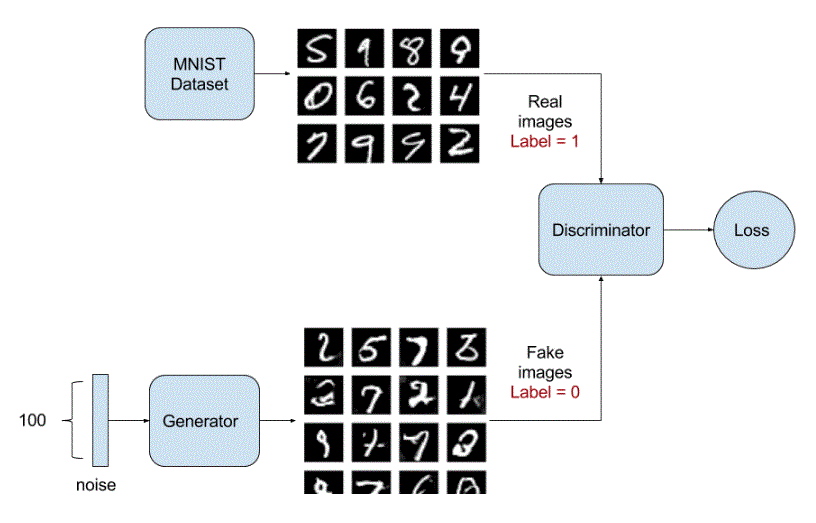

##### This notebook uses on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

### Import 

In [ ]:
from __future__ import absolute_import, division,print_function,unicode_literals

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

In [ ]:
!pip install -q imageio

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

### MNIST Dataset
After treining the generator will generate handwritten digits resembling the MNIST data.


In [ ]:
(train_images,train_labels),(_,_)=tf.keras.datasets.mnist.load_data()

In [ ]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[i],cmap='gray',interpolation='none')
    plt.title('class{}'.format(train_labels[i]))

In [ ]:
train_images=train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images=(train_images-127.5)/127.5

In [ ]:
BUFFER_SIZE=60000
BATCH_SIZE=256

In [ ]:
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [ ]:
def make_generator_model():
  model=tf.keras.Sequential()
  model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape==(None,7,7,256)
  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
  assert model.output_shape==(None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
  assert model.output_shape==(None,14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False))
  assert model.output_shape==(None,28,28,1)
  return model




Use the generator to create an image.


In [ ]:
generator=make_generator_model()
noise=tf.random.normal([1,100])
generated_image=generator(noise,training=False)

plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [ ]:
generator?

In [ ]:
# Describe why the image does not have a structure?

In [ ]:
# since the image is now just a noise and hence it is not having a structure

### The Discriminator

The discriminator is a CNN-based image classifier.

In [ ]:
def make_discriminator_model():
  model=tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
discriminator=make_discriminator_model()
decision=discriminator(generated_image)
print(decision)

In [ ]:
discriminator?

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [ ]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
def discriminator_loss(real_output,fake_output):
  real_loss=cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss=real_loss+fake_loss
  return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [ ]:
generator_optimizer=tf.keras.optimizers.Adam(1e-4) 
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

In [ ]:
# generator_optimizer.appply_gradients(zip(gradients_of_generator,generator.trainable_variables))

In [ ]:
tf.keras.optimizers.Adam?

### Save checkpoints
It is useful in case a long running training task is interrupted.


In [ ]:
tf.train.Checkpoint?

In [ ]:
checkpoint_dir='./training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                               discriminator_optimizer=discriminator_optimizer,
                               generator=generator,
                               discriminator=discriminator)

## Training loop



In [ ]:
EPOCHS=50
noise_dim=100
num_examples_to_generate=16

In [ ]:
tf.random.normal?

In [ ]:
seed=tf.random.normal([num_examples_to_generate,noise_dim])

In [ ]:
EPOCHS=60

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
@tf.function
def train_step(images):
  noise=tf.random.normal([BATCH_SIZE,noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images=generator(noise,training=True)

    real_output=discriminator(images,training=True)
    fake_output=discriminator(generated_images,training=True)

    gen_loss=generator_loss(fake_output)
    disc_loss=discriminator_loss(real_output,fake_output)

  gradients_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradients_of_discriminator=disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

In [ ]:
def train(dataset,epochs):
  for epochs in range(epochs):
    start=time.time()
    for image_batch in dataset:
      train_step(image_batch)
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs+1,seed)
    if (epochs+1)%15==0:
      checkpoint.save(file_prefix=checkpoint_prefix)
    print('time for epoch{} is {} sec'.format(epochs+1,time.time()-start))
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)

**Generate and save images**



In [ ]:
def generate_and_save_images(model,epoch,test_input):
  predictions=model(test_input,training=False)
  fig=plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


## Train the model
train() - training the generator and discriminator simultaneously. 
It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits.

In [ ]:
# Save your Jupyter Notebook before start the next cell

In [ ]:
train(train_dataset,EPOCHS)

Restore the latest checkpoint.

image.png

### Show the result as a GIF-file


In [ ]:
def display_images(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
def display_images(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

image.png

In [ ]:
display_images(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file='dcgan.gif'
with imageio.get_writer(anim_file,mode='I') as writer:
  filenames=glob.glob('image*.png')
  filenames=sorted(filenames)
  last=-1
  for i, filename in enumerate(filenames):
    frame=2*(i**0.5)
    if round(frame)>round(last):
      last=frame
    else:
      continue
    image=imageio.imread(filename)
    writer.append_data(image)
  image=imageio.imread(filename)
  writer.append_data(image)
import IPython
if IPython.version_info>(6,2,0,''):
  display.Image(filename=anim_file)


If you're working in Colab you can download the animation with the code below:

In [ ]:
try:
  from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)


source:
[Introducing TF-GAN: A lightweight GAN library for TensorFlow 2.0](https://medium.com/tensorflow/introducing-tf-gan-a-lightweight-gan-library-for-tensorflow-2-0-36d767e1abae)